In [191]:
from keras.datasets import mnist
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage import feature, exposure


In [66]:
# Specify the path to your mnist.npz file
file_path = 'mnist.npz'

# Load the dataset
with np.load(file_path) as data:
    x_train = data['x_train']
    y_train = data['y_train']
    x_test = data['x_test']
    y_test = data['y_test']

# Check the shapes of the loaded data
print("Training data shape:", x_train.shape)  # Should output (60000, 28, 28)
print("Training labels shape:", y_train.shape)  # Should output (60000,)
print("Test data shape:", x_test.shape)   # Should output (10000, 28, 28)
print("Test labels shape:", y_test.shape)   # Should output (10000,)

Training data shape: (60000, 28, 28)
Training labels shape: (60000,)
Test data shape: (10000, 28, 28)
Test labels shape: (10000,)


In [67]:
def convolution2d(image, kernel):
    # Get the dimensions of the image and kernel
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape
    
    # Calculate output dimensions
    output_height = image_height - kernel_height + 1
    output_width = image_width - kernel_width + 1
    
    # Create an output array with the calculated dimensions
    output = np.zeros((output_height, output_width))
    
    # Perform convolution operation
    for i in range(output_height):
        for j in range(output_width):
            # Multiply the current section of the image by the kernel and sum it up
            output[i, j] = np.sum(image[i:i+kernel_height, j:j+kernel_width] * kernel)
    
    return output

0 Padding

In [77]:
pad_width = 1

# padded_x_test = np.array([])
padded_x_test = np.empty((10000, 30, 30),  dtype=int)
padded_x_train = np.empty((60000, 30, 30),  dtype=int)


for i in range(10000):
    original_image = x_test[i]
    padded_image = np.pad(original_image, pad_width=pad_width, mode='constant', constant_values=0)
    padded_x_test[i] = padded_image

for i in range(60000):
    original_image = x_train[i]
    padded_image = np.pad(original_image, pad_width=pad_width, mode='constant', constant_values=0)
    padded_x_train[i] = padded_image


Sobel 1

In [78]:
kernel = np.empty((3, 3), dtype=int)

# Correctly assign a 2D array to the first slice of the kernel
kernel = np.array([[1, 0, -1],
                   [2, 0, -2],
                   [1, 0, -1]])

# padded_x_test = np.array([])
sobel1_x_test = np.empty((10000, 28, 28),  dtype=int)
sobel1_x_train = np.empty((60000, 28, 28),  dtype=int)


for i in range(10000):
    original_image = padded_x_test[i]
    temp = convolution2d(original_image, kernel)
    sobel1_x_test[i] = temp

for i in range(60000):
    original_image = padded_x_train[i]
    temp = convolution2d(original_image, kernel)
    sobel1_x_train[i] = temp


Sobel2


In [80]:
kernel = np.empty((3, 3), dtype=int)

# Correctly assign a 2D array to the first slice of the kernel
kernel = np.array([[1, 2, 1],
                   [0, 0, 0],
                   [-1, -2, -1]])

# padded_x_test = np.array([])
sobel2_x_test = np.empty((10000, 28, 28),  dtype=int)
sobel2_x_train = np.empty((60000, 28, 28),  dtype=int)


for i in range(10000):
    original_image = padded_x_test[i]
    temp = convolution2d(original_image, kernel)
    sobel2_x_test[i] = temp

for i in range(60000):
    original_image = padded_x_train[i]
    temp = convolution2d(original_image, kernel)
    sobel2_x_train[i] = temp

Sobel final

In [100]:
x = sobel1_x_test
y = sobel2_x_test
sobel_x_test = np.sqrt(x**2 + y**2)

x = sobel1_x_train
y = sobel2_x_train
sobel_x_train = np.sqrt(x**2 + y**2)

print(sobel_x_train.shape)
print(sobel_x_test.shape)
# print(sobel_x_train[50000])

(60000, 28, 28)
(10000, 28, 28)


Sobel normalization

In [102]:
result_min = sobel_x_test.min()
result_max = sobel_x_test.max()
if result_max - result_min > 0:
    normalized_result = (sobel_x_test - result_min) / (result_max - result_min)
else:
    normalized_result = np.zeros_like(sobel_x_test)  # All values are the same

# Step 2: Scale to [0, 255]
sobel_x_test_final = normalized_result * 255

# Step 3: Convert to int
sobel_x_test_final = sobel_x_test_final.astype(int)
print("Shape of the scaled result:", sobel_x_test_final.shape)
print("Min value in scaled result:", sobel_x_test_final.min())
print("Max value in scaled result:", sobel_x_test_final.max())
# print(scaled_result[400])

Shape of the scaled result: (10000, 28, 28)
Min value in scaled result: 0
Max value in scaled result: 255


In [109]:
result_min = sobel_x_train.min()
result_max = sobel_x_train.max()
if result_max - result_min > 0:
    normalized_result = (sobel_x_train - result_min) / (result_max - result_min)
else:
    normalized_result = np.zeros_like(sobel_x_train)  # All values are the same

# Step 2: Scale to [0, 255]
sobel_x_train_final = normalized_result * 255

# Step 3: Convert to int
sobel_x_train_final = sobel_x_train_final.astype(int)
print("Shape of the scaled result:", sobel_x_train_final.shape)
print("Min value in scaled result:", sobel_x_train_final.min())
print("Max value in scaled result:", sobel_x_train_final.max())


Shape of the scaled result: (60000, 28, 28)
Min value in scaled result: 0
Max value in scaled result: 255


Save Sobel

In [ ]:

np.save('sobel_x_train_final.npy', sobel_x_train_final)
np.save('sobel_x_test_final.npy', sobel_x_test_final)



Load Sobel


In [117]:
sobel_x_train_final = np.load('sobel_x_train_final.npy')

sobel_x_test_final = np.load('sobel_x_test_final.npy')

HOG

In [205]:
orientations = 9
pixels_per_cell = (4,4)  # Set to (4, 4) for better feature extraction on small images
cells_per_block = (2, 2)   # Set to (2, 2) for normalization


HOG_test = np.empty((10000, 28, 28))
HOG_test_f = np.empty((10000, 6, 6, 2, 2, 9))

HOG_train = np.empty((60000, 28, 28))
HOG_train_f = np.empty((60000, 6, 6, 2, 2, 9))


for i in range(10000):
    original_image = x_test[i]
    hog_features, hog_image = feature.hog(original_image, orientations=orientations,
                                       pixels_per_cell=pixels_per_cell,
                                       cells_per_block=cells_per_block,
                                       visualize=True, feature_vector=False)
    HOG_test[i] = hog_image
    HOG_test_f[i] = hog_features

for i in range(60000):
    original_image = x_train[i]
    hog_features, hog_image = feature.hog(original_image, orientations=orientations,
                                       pixels_per_cell=pixels_per_cell,
                                       cells_per_block=cells_per_block,
                                       visualize=True, feature_vector=False)
    HOG_train[i] = hog_image
    HOG_train_f[i] = hog_features

save HOG

In [210]:
np.save('HOG_train.npy', HOG_train)
np.save('HOG_train_f.npy', HOG_train_f)

np.save('HOG_test.npy', HOG_test)
np.save('HOG_test_f.npy', HOG_test_f)

Load HOG

In [211]:
HOG_test = np.load('HOG_test.npy')
HOG_test_f = np.load('HOG_test_f.npy')

HOG_train = np.load('HOG_train.npy')
HOG_train_f = np.load('HOG_train_f.npy')

(28, 28)


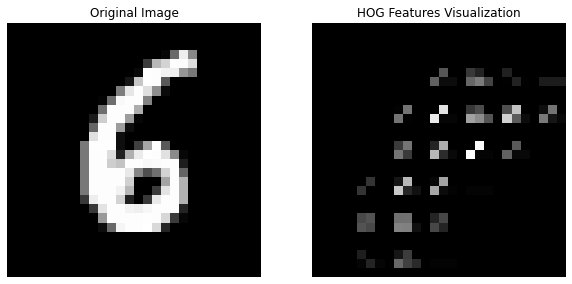

In [209]:
image = x_test[986]

orientations = 9
pixels_per_cell = (4, 4)
cells_per_block = (2, 2)

hog_features, hog_image = feature.hog(image, orientations=orientations,
                                       pixels_per_cell=pixels_per_cell,
                                       cells_per_block=cells_per_block,
                                       visualize=True, feature_vector=False)


hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))


# print(hog_features)
print(hog_image.shape)
# Step 4: Plotting the results
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('HOG Features Visualization')
plt.imshow(HOG_train[59999], cmap='gray')
plt.axis('off')

plt.show()

In [ ]:
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, exposure


image = data.astronaut()

fd, hog_image = hog(
    image,
    orientations=8,
    pixels_per_cell=(16, 16),
    cells_per_block=(1, 1),
    visualize=True,
    channel_axis=-1,
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()
print(fd.min())

ModuleNotFoundError: The requested file is part of the scikit-image distribution, but requires the installation of an optional dependency, pooch. To install pooch, use your preferred python package manager. Follow installation instruction found at https://scikit-image.org/docs/stable/user_guide/install.html

In [118]:
# print(padded_x_test.shape)
# print(padded_x_train[59999])
print(type(sobel_x_test_final))

<class 'numpy.ndarray'>


0


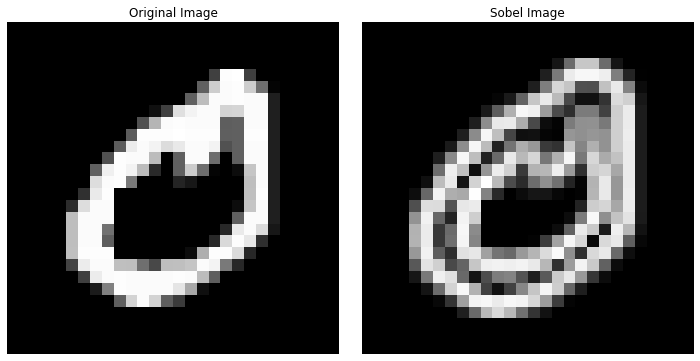

In [113]:

plt.figure(figsize=(10, 5))

# First subplot for the original image
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.title('Original Image')
plt.imshow(x_train[21], cmap='gray')
plt.axis('off')  # Hide axis ticks

# Second subplot for the Sobel image (or scaled result)
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.title('Sobel Image')
plt.imshow(sobel_x_train_final[21], cmap='gray')
plt.axis('off')  # Hide axis ticks
print(y_train[21])
# Show the plots
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()